[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ykitaguchi77/Eyelid_segmentation_inference/blob/main/inference_yolo.ipynb)

# YOLO11 Detection Inference

YOLOv11モデルを使用した物体検出推論

In [183]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [ ]:
# モデルパス 
MODEL_PATH = r"C:\Users\CorneAI\Eyelid_seg_inference\YOLO11n-detect.pt"

# モデルをロード
model = YOLO(MODEL_PATH)
print(f"Model loaded: {MODEL_PATH}")
print(f"Model names: {model.names}")

Model loaded: C:\Users\CorneAI\Eyelid_seg_inference\YOLO11n-detect.pt
Model names: {0: 'Right_eye', 1: 'Left_eye'}


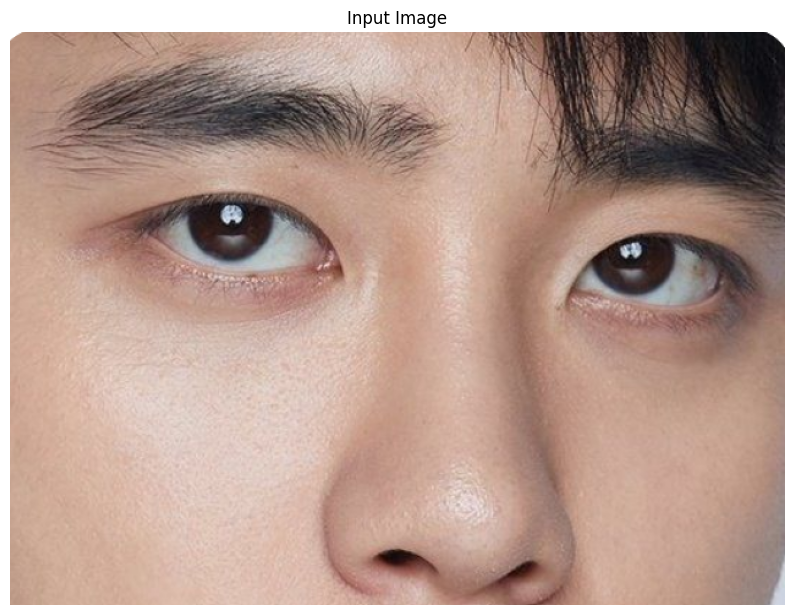

In [185]:
# 入力画像パス
IMAGE_PATH = r"C:\Users\CorneAI\Eyelid_seg_inference\sample_image.png"

# 画像を読み込み
img = cv2.imread(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 元画像を表示
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title("Input Image")
plt.axis('off')
plt.show()

In [186]:
# 推論を実行
results = model.predict(
    source=IMAGE_PATH,
    conf=0.25,  # 信頼度閾値
    iou=0.45,   # NMS IoU閾値
    verbose=True
)

# 結果を取得
result = results[0]
print(f"検出数: {len(result.boxes)}")


image 1/1 C:\Users\CorneAI\Eyelid_seg_inference\sample_image.png: 480x640 1 Right_eye, 1 Left_eye, 78.1ms
Speed: 4.7ms preprocess, 78.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
検出数: 2


[0] Class: Right_eye, Confidence: 0.956
    BBox (xyxy): [112.3, 140.2, 271.6, 196.6]
[1] Class: Left_eye, Confidence: 0.953
    BBox (xyxy): [456.9, 167.5, 583.1, 225.5]


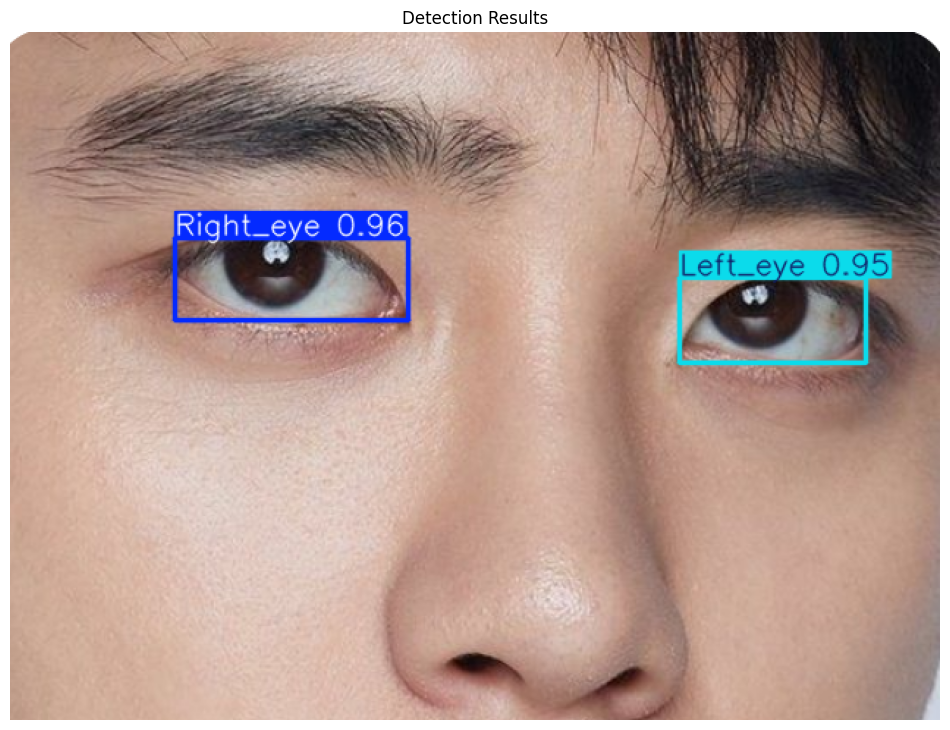

In [187]:
# 検出結果の詳細を表示
for i, box in enumerate(result.boxes):
    cls_id = int(box.cls[0])
    cls_name = model.names[cls_id]
    conf = float(box.conf[0])
    xyxy = box.xyxy[0].cpu().numpy()
    
    print(f"[{i}] Class: {cls_name}, Confidence: {conf:.3f}")
    print(f"    BBox (xyxy): [{xyxy[0]:.1f}, {xyxy[1]:.1f}, {xyxy[2]:.1f}, {xyxy[3]:.1f}]")

# 検出結果を可視化
result_img = result.plot()
result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(result_img_rgb)
plt.title("Detection Results")
plt.axis('off')
plt.show()

In [188]:
# 結果を保存
output_path = Path(IMAGE_PATH).stem + "_result.jpg"
cv2.imwrite(output_path, result_img)
print(f"Result saved to: {output_path}")

Result saved to: sample_image_result.jpg


## ROI Extraction for Segmentation

検出した眼瞼領域からマージンを付けてROIを抽出し、セグメンテーション用画像を作成

In [189]:
def extract_roi(image, bbox, roi_size=512, expansion_ratio=0.25):
    """BBoxからROIを抽出（マージン付き、正方形化）"""
    h, w = image.shape[:2]
    x1, y1, x2, y2 = bbox
    
    # 中心と拡張後のサイズ
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    side = max(x2 - x1, y2 - y1) * (1 + 2 * expansion_ratio)
    
    # 拡張後の座標
    nx1, ny1 = int(cx - side / 2), int(cy - side / 2)
    nx2, ny2 = int(cx + side / 2), int(cy + side / 2)
    
    # パディング量（ROIが画像外にはみ出す場合、その分を黒で埋める）
    pad = [max(0, -ny1), max(0, ny2 - h), max(0, -nx1), max(0, nx2 - w)]  # top, bottom, left, right
    
    # クロップ（画像範囲内のみ）
    roi = image[max(0, ny1):min(h, ny2), max(0, nx1):min(w, nx2)].copy()
    
    # 画像端の目など、ROIが画像外にはみ出す場合は黒(0,0,0)でパディング
    if any(pad):
        roi = cv2.copyMakeBorder(roi, *pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    return cv2.resize(roi, (roi_size, roi_size))

Right_eye: ROI extracted (512x512)
Left_eye: ROI extracted (512x512)


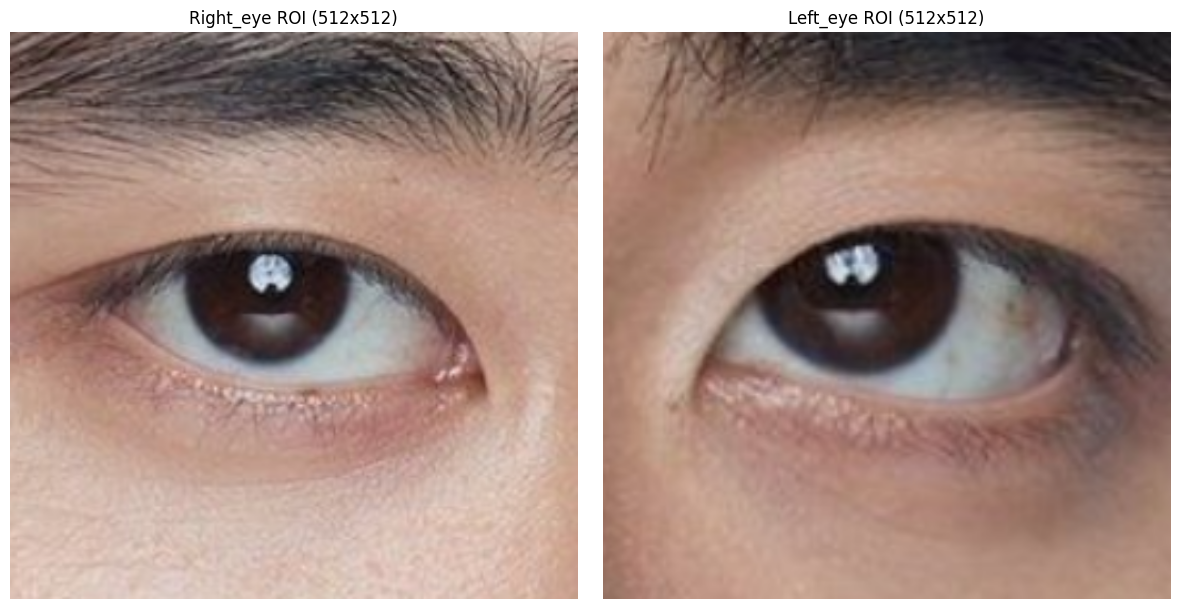

In [190]:
# 検出したBBoxからROIを抽出
rois = []
class_names = []

for box in result.boxes:
    cls_name = model.names[int(box.cls[0])]
    bbox = box.xyxy[0].cpu().numpy()
    
    roi = extract_roi(img, bbox)
    rois.append(roi)
    class_names.append(cls_name)
    
    print(f"{cls_name}: ROI extracted (512x512)")

# 抽出したROIを表示
fig, axes = plt.subplots(1, len(rois), figsize=(6 * len(rois), 6))
if len(rois) == 1:
    axes = [axes]

for ax, roi, name in zip(axes, rois, class_names):
    ax.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{name} ROI (512x512)")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [191]:
# ROI画像を保存
image_stem = Path(IMAGE_PATH).stem

for roi, name in zip(rois, class_names):
    roi_path = f"{image_stem}_{name}_roi.png"
    cv2.imwrite(roi_path, roi)
    print(f"Saved: {roi_path}")

Saved: sample_image_Right_eye_roi.png
Saved: sample_image_Left_eye_roi.png


## Segmentation Inference

ROI画像に対してセグメンテーション推論を実行

In [192]:
# セグメンテーションモデルをロード
SEG_MODEL_PATH = r"C:\Users\CorneAI\Eyelid_seg_inference\YOLO11n-seg.pt"

seg_model = YOLO(SEG_MODEL_PATH)
print(f"Segmentation model loaded: {SEG_MODEL_PATH}")
print(f"Classes: {seg_model.names}")

Segmentation model loaded: C:\Users\CorneAI\Eyelid_seg_inference\YOLO11n-seg.pt
Classes: {0: 'conj', 1: 'caruncle', 2: 'iris_vis', 3: 'iris_occ', 4: 'pupil_vis', 5: 'pupil_occ'}


In [193]:
# 各ROIに対してセグメンテーション推論を実行
seg_results = []

for roi, name in zip(rois, class_names):
    result = seg_model.predict(
        source=roi,
        conf=0.25,
        retina_masks=True,  # 高解像度マスク
        verbose=False
    )[0]
    seg_results.append(result)
    
    print(f"{name}: {len(result.boxes)} objects detected")

Right_eye: 5 objects detected
Left_eye: 6 objects detected


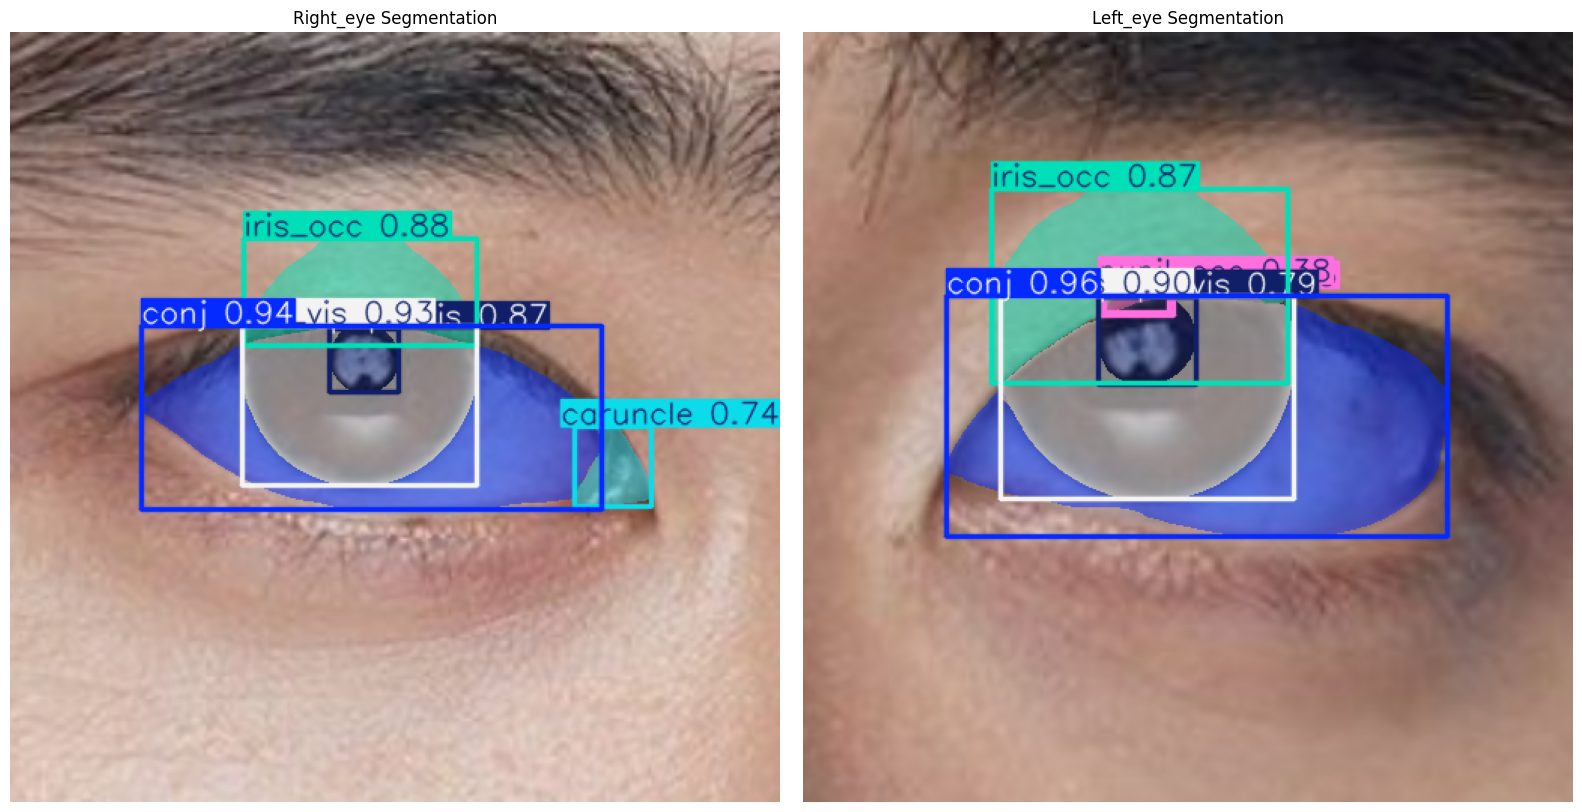

In [194]:
# セグメンテーション結果を表示
fig, axes = plt.subplots(1, len(seg_results), figsize=(8 * len(seg_results), 8))
if len(seg_results) == 1:
    axes = [axes]

for ax, seg_result, name in zip(axes, seg_results, class_names):
    # 結果を描画
    result_img = seg_result.plot()
    ax.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{name} Segmentation")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [195]:
# セグメンテーション結果を保存
for seg_result, name in zip(seg_results, class_names):
    result_img = seg_result.plot()
    seg_path = f"{image_stem}_{name}_seg.png"
    cv2.imwrite(seg_path, result_img)
    print(f"Saved: {seg_path}")

Saved: sample_image_Right_eye_seg.png
Saved: sample_image_Left_eye_seg.png


## Ellipse Fitting & Eyelid Contour

- Eyelid（conj + iris_vis + pupil_vis）: 眼瞼開口部の輪郭（黄）
- Iris（iris_vis + iris_occ）: 虹彩の楕円近似（緑）
- Pupil（pupil_vis + pupil_occ）: 瞳孔の楕円近似（青）

In [196]:
def fit_ellipse_to_mask(mask):
    """マスクから楕円をフィッティング"""
    # 輪郭を抽出
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    
    # 最大の輪郭を使用
    contour = max(contours, key=cv2.contourArea)
    
    # 楕円フィッティングには最低5点必要
    if len(contour) < 5:
        return None
    
    return cv2.fitEllipse(contour)

def get_combined_mask(seg_result, class_names_to_combine, seg_model):
    """指定したクラスのマスクを結合（iris_vis + iris_occ → full iris）"""
    if seg_result.masks is None:
        return None
    
    h, w = seg_result.masks.data.shape[1:]
    combined = np.zeros((h, w), dtype=np.uint8)
    
    for i, box in enumerate(seg_result.boxes):
        cls_name = seg_model.names[int(box.cls[0])]
        if cls_name in class_names_to_combine:
            mask = seg_result.masks.data[i].cpu().numpy()
            combined = np.maximum(combined, (mask * 255).astype(np.uint8))
    
    return combined if combined.any() else None

In [197]:
# Eyelid（conj+iris_vis+pupil_vis）、Iris、Pupil のマスクを取得して描画
ellipse_results = []

for roi, seg_result, eye_name in zip(rois, seg_results, class_names):
    result_img = roi.copy()
    ellipses = {}
    
    # Eyelid mask = conj + iris_vis + pupil_vis（眼瞼開口部全体）
    eyelid_mask = get_combined_mask(seg_result, ['conj', 'iris_vis', 'pupil_vis'], seg_model)
    if eyelid_mask is not None:
        contours, _ = cv2.findContours(eyelid_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cv2.drawContours(result_img, contours, -1, (0, 255, 255), 2)  # 黄色
            print(f"{eye_name} Eyelid: contour drawn (conj + iris_vis + pupil_vis)")
    
    # Full Iris (iris_vis + iris_occ) → 楕円近似
    iris_mask = get_combined_mask(seg_result, ['iris_vis', 'iris_occ'], seg_model)
    if iris_mask is not None:
        iris_ellipse = fit_ellipse_to_mask(iris_mask)
        if iris_ellipse:
            ellipses['iris'] = iris_ellipse
            cv2.ellipse(result_img, iris_ellipse, (0, 255, 0), 2)  # 緑
            print(f"{eye_name} Iris: center=({iris_ellipse[0][0]:.1f}, {iris_ellipse[0][1]:.1f}), "
                  f"axes=({iris_ellipse[1][0]:.1f}, {iris_ellipse[1][1]:.1f}), angle={iris_ellipse[2]:.1f}")
    
    # Full Pupil (pupil_vis + pupil_occ) → 楕円近似
    pupil_mask = get_combined_mask(seg_result, ['pupil_vis', 'pupil_occ'], seg_model)
    if pupil_mask is not None:
        pupil_ellipse = fit_ellipse_to_mask(pupil_mask)
        if pupil_ellipse:
            ellipses['pupil'] = pupil_ellipse
            cv2.ellipse(result_img, pupil_ellipse, (255, 0, 0), 2)  # 青
            print(f"{eye_name} Pupil: center=({pupil_ellipse[0][0]:.1f}, {pupil_ellipse[0][1]:.1f}), "
                  f"axes=({pupil_ellipse[1][0]:.1f}, {pupil_ellipse[1][1]:.1f}), angle={pupil_ellipse[2]:.1f}")
    
    ellipse_results.append({'image': result_img, 'ellipses': ellipses, 'eye_name': eye_name})

Right_eye Eyelid: contour drawn (conj + iris_vis + pupil_vis)
Right_eye Iris: center=(232.2, 219.2), axes=(156.8, 164.2), angle=8.1
Right_eye Pupil: center=(234.8, 216.8), axes=(44.9, 47.2), angle=101.6
Left_eye Eyelid: contour drawn (conj + iris_vis + pupil_vis)
Left_eye Iris: center=(225.9, 205.9), axes=(198.4, 212.4), angle=152.9
Left_eye Pupil: center=(227.2, 201.8), axes=(65.2, 67.1), angle=158.1


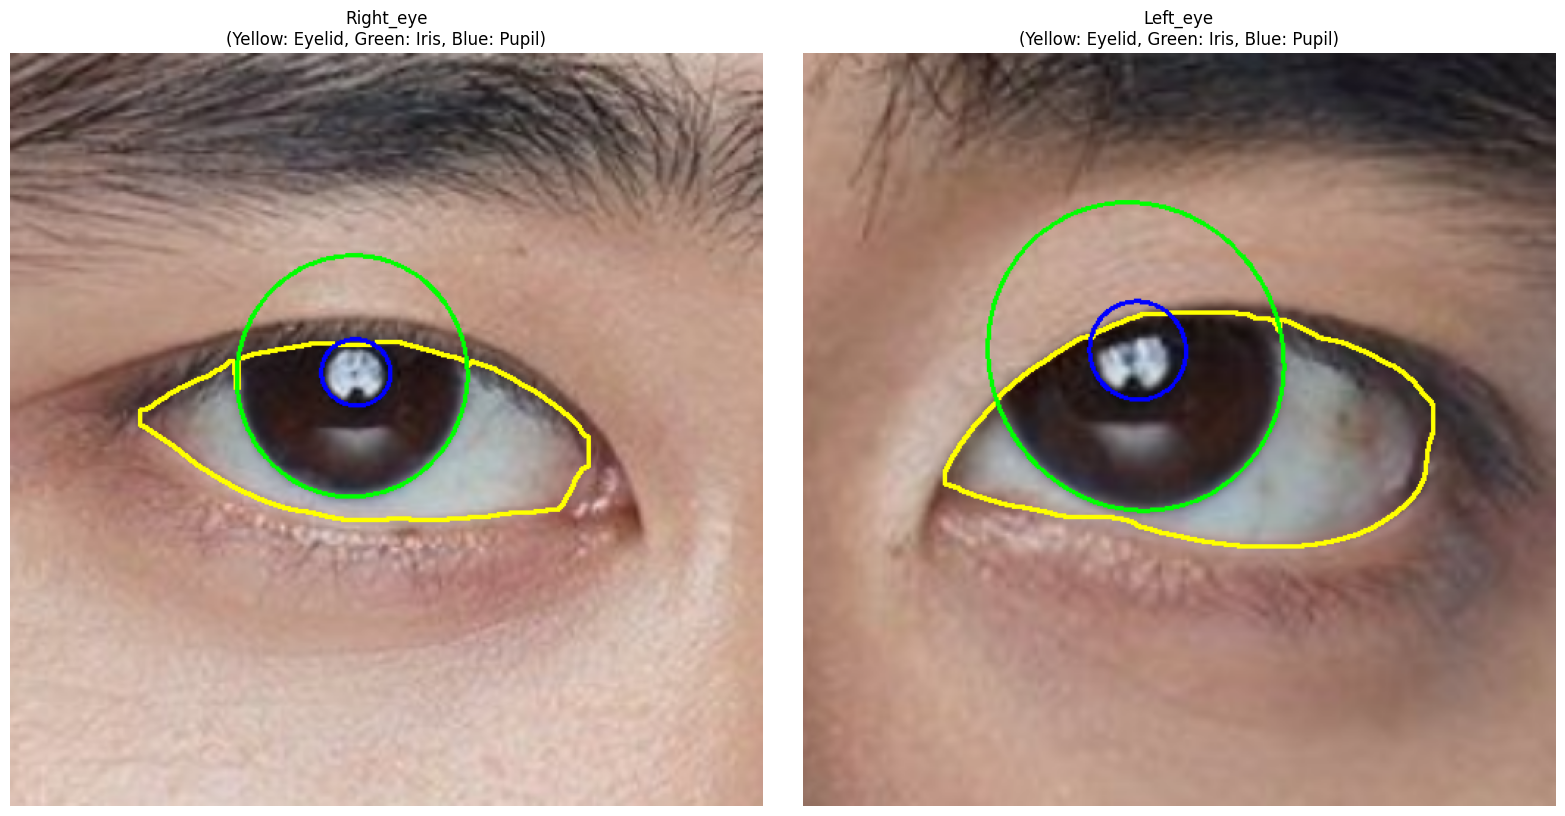

In [198]:
# 結果を表示（黄: Eyelid、緑: Iris、青: Pupil）
fig, axes = plt.subplots(1, len(ellipse_results), figsize=(8 * len(ellipse_results), 8))
if len(ellipse_results) == 1:
    axes = [axes]

for ax, res in zip(axes, ellipse_results):
    ax.imshow(cv2.cvtColor(res['image'], cv2.COLOR_BGR2RGB))
    ax.set_title(f"{res['eye_name']}\n(Yellow: Eyelid, Green: Iris, Blue: Pupil)")
    ax.axis('off')

plt.tight_layout()
plt.show()